# House shape classification
### Yonsei App.Stat. 
### Sunwoo Kim

다양한 Graph XAI 분야의 논문들은 데이터로 house shape를 포함하는가 확인하는 데이터를 사용하곤 합니다.  
이 synthetic data를 생성하고, 분류하는 모형을 제작하도록 하겠습니다.

## Generating random graphs

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader
# Network generating
from network_generator import *
# Defining model 
from GNN_models import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
data_model = BA_house_generator(max_n= 15, 
                          min_n = 10, 
                          edge_rate = 2,
                          data_type = "single_house",
                          r_seed = -0)

In [3]:
data_model.dataset_generator(num_graph = 1000)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4628.58it/s]


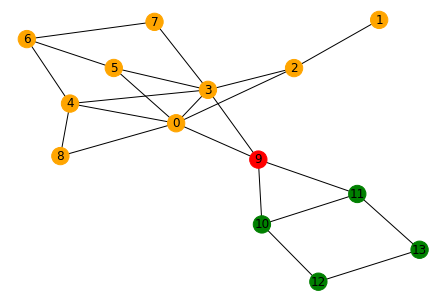

In [4]:
data_model.visualization(0)

In [5]:
data_module = DataLoader(data_model.data_list, 
                        batch_size = 10)

## Defining GNN models

GNN 모델을 생성합니다.  
GNN architecture는 Graph SAGE를 사용하였고, 층은 8차원짜리 하나만 쌓았습니다.

In [17]:
model = house_classifier(dataset = data_model.data_list[0], 
                        latent_dim = [8]).to(device)

In [18]:
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

model.train()
for epoch in range(15):
    for data in data_module : 
        data.to(device)
        optimizer.zero_grad()
        out = model(data = data, 
                   training_with_batch = True)
        loss = F.binary_cross_entropy(out.view(-1), data.y)
        loss.backward()
        optimizer.step()
    print(loss)

C:\Users\kswoo\Anaconda3\envs\sunwoo_env\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.3321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1437, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0621, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0019, devic

Loss가 잘 떨어지는 것이 확인가능합니다.  
이제 test data에 대해 적용해보겠습니다.

### Testing Accuracy

In [19]:
test_model = BA_house_generator(max_n= 15, 
                          min_n = 10, 
                          edge_rate = 2,
                          data_type = "single_house",
                          r_seed = 1000)
test_model.dataset_generator(num_graph = 1000)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4607.27it/s]


In [20]:
model.to("cpu")
acc = 0
for i in range(len(test_model.data_list)) : 
    y_hat = model(data = test_model.data_list[i], 
         training_with_batch = False)
    if y_hat > 0.5 : pred = 1
    else : pred = 0
    if pred == test_model.data_list[i].y.item() : 
        acc += 1

In [21]:
acc/1000

1.0

정확도 1.0으로 완벽하게 분류하는 것을 확인할 수 있습니다.  
이 데이터와 모델을 GNN-Explainer나 PG-Explainer에 활용할 수 있겠습니다.